In [ ]:
import pandas as pd
import numpy as np
 
#data = pd.read_csv('Major_Crime_Indicators.csv')
 
from google.colab import drive
drive.mount('/content/drive/')
path = '/content/drive/MyDrive/Group 2_ML3253_Term Project/Major_Crime_Indicators.csv'
data = pd.read_csv(path)
 
data.head()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (24) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,X,Y,Index_,event_unique_id,Division,occurrencedate,reporteddate,premises_type,ucr_code,ucr_ext,offence,reportedyear,reportedmonth,reportedday,reporteddayofyear,reporteddayofweek,reportedhour,occurrenceyear,occurrencemonth,occurrenceday,occurrencedayofyear,occurrencedayofweek,occurrencehour,MCI,Hood_ID,Neighbourhood,Long,Lat,ObjectId
0,-8.859749e+06,5.423033e+06,10182,GO-20142103239,D23,2014/05/18 04:00:00+00,2014/05/18 04:00:00+00,House,1430,100,Assault,2014,May,18,138,Sunday,12,2014.0,May,18.0,138.0,Sunday,12,Assault,1,West Humber-Clairville (1),-79.588477,43.725321,1
1,-8.861050e+06,5.426864e+06,10298,GO-20142111528,D23,2014/05/19 04:00:00+00,2014/05/19 04:00:00+00,Outside,1430,100,Assault,2014,May,19,139,Monday,21,2014.0,May,19.0,139.0,Monday,20,Assault,1,West Humber-Clairville (1),-79.600166,43.750187,2
2,-8.861412e+06,5.422084e+06,10300,GO-20142111859,D23,2014/05/19 04:00:00+00,2014/05/19 04:00:00+00,Apartment,2120,200,B&E,2014,May,19,139,Monday,22,2014.0,May,19.0,139.0,Monday,22,Break and Enter,1,West Humber-Clairville (1),-79.603420,43.719158,3
3,-8.859955e+06,5.424372e+06,10345,GO-20142116041,D23,2014/05/20 04:00:00+00,2014/05/20 04:00:00+00,Outside,1420,100,Assault With Weapon,2014,May,20,140,Tuesday,14,2014.0,May,20.0,140.0,Tuesday,14,Assault,1,West Humber-Clairville (1),-79.590332,43.734013,4
4,-8.859955e+06,5.424372e+06,10346,GO-20142116041,D23,2014/05/20 04:00:00+00,2014/05/20 04:00:00+00,Outside,1420,110,Assault Bodily Harm,2014,May,20,140,Tuesday,14,2014.0,May,20.0,140.0,Tuesday,14,Assault,1,West Humber-Clairville (1),-79.590332,43.734013,5


In [ ]:
data.info()

# Data Cleaning

Explain briefly what do we do for data cleaning

In [ ]:
# unique_data = data.drop(['X', 'Y', 'Index_'], axis=1).drop_duplicates(subset=['event_unique_id'])

unique_data = data.drop(['Index_'], axis=1).drop_duplicates(subset=['event_unique_id']).reset_index()
unique_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211366 entries, 0 to 211365
Data columns (total 29 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   index                211366 non-null  int64  
 1   X                    211366 non-null  float64
 2   Y                    211366 non-null  float64
 3   event_unique_id      211366 non-null  object 
 4   Division             211366 non-null  object 
 5   occurrencedate       211366 non-null  object 
 6   reporteddate         211366 non-null  object 
 7   premises_type        211366 non-null  object 
 8   ucr_code             211366 non-null  int64  
 9   ucr_ext              211366 non-null  int64  
 10  offence              211366 non-null  object 
 11  reportedyear         211366 non-null  int64  
 12  reportedmonth        211366 non-null  object 
 13  reportedday          211366 non-null  int64  
 14  reporteddayofyear    211366 non-null  int64  
 15  reporteddayofweek

In [ ]:
# transforming day_of_week and month_name from string to number
day_of_week = {
  'Monday': 0,
  'Tuesday': 1,
  'Wednesday': 2,
  'Thursday': 3,
  'Friday': 4,
  'Saturday': 5,
  'Sunday': 6
}

unique_data['occurrencedayofweek_numeric'] = unique_data['occurrencedayofweek'].apply(lambda m: day_of_week.get(m))

month_name = {
  'January': 1,
  'February': 2,
  'March': 3,
  'April': 4,
  'May': 5,
  'June': 6,
  'July': 7,
  'August': 8,
  'September': 9,
  'October': 10,
  'November': 11,
  'December': 12
}

unique_data['occurrencemonth_numeric'] = unique_data['occurrencemonth'].apply(lambda m: month_name.get(m))

In [ ]:
# testing to make sure missing values belong to the same rows
missing_year = unique_data.loc[unique_data['occurrenceyear'].isnull()]
missing_month = unique_data.loc[unique_data['occurrencemonth'].isnull()]
missing_day = unique_data.loc[unique_data['occurrenceday'].isnull()]
missing_doy = unique_data.loc[unique_data['occurrencedayofyear'].isnull()]
missing_dow = unique_data.loc[unique_data['occurrencedayofweek'].isnull()]

print(missing_year.equals(missing_month))
print(missing_year.equals(missing_day))
print(missing_year.equals(missing_doy))
print(missing_year.equals(missing_dow))

True
True
True
True


In [ ]:
# update missing values
from datetime import datetime
f = '%Y/%m/%d %H:%M:%S+%f'
missing_year = unique_data.loc[unique_data['occurrenceyear'].isnull()]

for row in missing_year.itertuples():
  occurrence_date = datetime.strptime(row.occurrencedate, f)
  values = {
    'occurrenceyear': int(occurrence_date.strftime('%Y')),
    'occurrencemonth_numeric': int(occurrence_date.strftime('%m')), 
    'occurrenceday': int(occurrence_date.strftime('%d')), 
    'occurrencedayofyear': occurrence_date.timetuple().tm_yday, 
    'occurrencedayofweek_numeric': occurrence_date.weekday()
  }
  unique_data.fillna(value=values, limit=1, inplace=True)

# TODO: have testing to make sure we didn't mess up data

In [ ]:
# label encoding the MCI
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(unique_data['MCI'])
le.classes_
unique_data['MCI_number'] = le.transform(unique_data['MCI'])
unique_data['MCI_number'].value_counts()

# factorize premises_type
labels, uniques = pd.factorize(unique_data['premises_type'])
print("Unique Values : \n", uniques)
unique_data['premises_type_numeric'] = labels

Unique Values : 
 Index(['House', 'Outside', 'Apartment', 'Commercial', 'Other', 'Educational',
       'Transit'],
      dtype='object')


# Identify NSA

In [ ]:
# unique_data[unique_data.eq("NSA").any(1)]
unique_data[unique_data['Division']=='NSA'].shape

(711, 33)

In [ ]:
unique_data[unique_data['Hood_ID']=='NSA'].shape

(1002, 33)

In [ ]:
unique_data[(unique_data['Division']=='NSA') | (unique_data['Hood_ID']=='NSA')].shape

(1016, 33)

In [ ]:
unique_data[(unique_data['Division']=='NSA') & (unique_data['Hood_ID']=='NSA')].shape

(697, 33)

In [ ]:
unique_data[((unique_data['Division']=='NSA')|(unique_data['Hood_ID']=='NSA')) | ((unique_data['Division']=='NSA') & (unique_data['Hood_ID']=='NSA'))].shape

(1016, 33)

In [ ]:
unique_data[(unique_data['Division']!='NSA') & (unique_data['Hood_ID']!='NSA')].shape

(210350, 33)

# Drop NSA

In [ ]:
unique_data = unique_data[(unique_data['Division']!='NSA') & (unique_data['Hood_ID']!='NSA')].reset_index()

In [ ]:
unique_data.shape

(210350, 34)

In [ ]:
# check
unique_data[unique_data.eq("NSA").any(1)]

,level_0,index,X,Y,event_unique_id,Division,occurrencedate,reporteddate,premises_type,ucr_code,ucr_ext,offence,reportedyear,reportedmonth,reportedday,reporteddayofyear,reporteddayofweek,reportedhour,occurrenceyear,occurrencemonth,occurrenceday,occurrencedayofyear,occurrencedayofweek,occurrencehour,MCI,Hood_ID,Neighbourhood,Long,Lat,ObjectId,occurrencedayofweek_numeric,occurrencemonth_numeric,MCI_number,premises_type_numeric


In [ ]:
unique_data.drop(columns =['level_0','index'],axis=1) #drop these two columns

,X,Y,event_unique_id,Division,occurrencedate,reporteddate,premises_type,ucr_code,ucr_ext,offence,reportedyear,reportedmonth,reportedday,reporteddayofyear,reporteddayofweek,reportedhour,occurrenceyear,occurrencemonth,occurrenceday,occurrencedayofyear,occurrencedayofweek,occurrencehour,MCI,Hood_ID,Neighbourhood,Long,Lat,ObjectId,occurrencedayofweek_numeric,occurrencemonth_numeric,MCI_number,premises_type_numeric
0,-8.859749e+06,5.423033e+06,GO-20142103239,D23,2014/05/18 04:00:00+00,2014/05/18 04:00:00+00,House,1430,100,Assault,2014,May,18,138,Sunday,12,2014.0,May,18.0,138.0,Sunday,12,Assault,1,West Humber-Clairville (1),-79.588477,43.725321,1,6.0,5.0,0,0
1,-8.861050e+06,5.426864e+06,GO-20142111528,D23,2014/05/19 04:00:00+00,2014/05/19 04:00:00+00,Outside,1430,100,Assault,2014,May,19,139,Monday,21,2014.0,May,19.0,139.0,Monday,20,Assault,1,West Humber-Clairville (1),-79.600166,43.750187,2,0.0,5.0,0,1
2,-8.861412e+06,5.422084e+06,GO-20142111859,D23,2014/05/19 04:00:00+00,2014/05/19 04:00:00+00,Apartment,2120,200,B&E,2014,May,19,139,Monday,22,2014.0,May,19.0,139.0,Monday,22,Break and Enter,1,West Humber-Clairville (1),-79.603420,43.719158,3,0.0,5.0,2,2
3,-8.859955e+06,5.424372e+06,GO-20142116041,D23,2014/05/20 04:00:00+00,2014/05/20 04:00:00+00,Outside,1420,100,Assault With Weapon,2014,May,20,140,Tuesday,14,2014.0,May,20.0,140.0,Tuesday,14,Assault,1,West Humber-Clairville (1),-79.590332,43.734013,4,1.0,5.0,0,1
4,-8.858486e+06,5.419941e+06,GO-20142117288,D23,2014/05/20 04:00:00+00,2014/05/20 04:00:00+00,Commercial,1430,100,Assault,2014,May,20,140,Tuesday,18,2014.0,May,20.0,140.0,Tuesday,17,Assault,1,West Humber-Clairville (1),-79.577131,43.705244,8,1.0,5.0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210345,-8.816598e+06,5.427041e+06,GO-2018152123,D43,2018/01/24 05:00:00+00,2018/01/24 05:00:00+00,House,2120,200,B&E,2018,January,24,24,Wednesday,20,2018.0,January,24.0,24.0,Wednesday,20,Break and Enter,140,Guildwood (140),-79.200844,43.751335,241734,2.0,1.0,2,0
210346,-8.816269e+06,5.425963e+06,GO-2018170924,D43,2018/01/27 05:00:00+00,2018/01/27 05:00:00+00,Apartment,1430,100,Assault,2018,January,27,27,Saturday,19,2018.0,January,27.0,27.0,Saturday,19,Assault,140,Guildwood (140),-79.197893,43.744342,241735,5.0,1.0,0,2
210347,-8.817404e+06,5.426423e+06,GO-2018174053,D43,2018/01/28 05:00:00+00,2018/01/28 05:00:00+00,Commercial,2120,200,B&E,2018,January,28,28,Sunday,10,2018.0,January,28.0,28.0,Sunday,0,Break and Enter,140,Guildwood (140),-79.208090,43.747327,241736,6.0,1.0,2,3
210348,-8.817158e+06,5.425369e+06,GO-2018218181,D43,2018/02/04 05:00:00+00,2018/02/04 05:00:00+00,House,2120,220,B&E W'Intent,2018,February,4,35,Sunday,3,2018.0,February,4.0,35.0,Sunday,3,Break and Enter,140,Guildwood (140),-79.205876,43.740483,241737,6.0,2.0,2,0


# Data Visualization

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import folium
# from folium.plugins import HeatMap

# Geo data visualization with sample subset of MCI

In [ ]:
# create sample_mci data
sample_mci = unique_data.loc[unique_data['occurrenceyear'] == 2020.00].loc[unique_data['occurrencemonth'] == 'March'].loc[unique_data['MCI'] == 'Assault']
sample_mci.shape

(1202, 34)

In [ ]:
#geo_data_sample_mci = temp[['Lat','Long']]
#geo_data_sample_mci.head()

In [ ]:
#geo_data_sample_mci.shape

In [ ]:
#create a map
#this_map = folium.Map(prefer_canvas=True)

#def plotDot(point):
#    '''input: series that contains a numeric named latitude and a numeric named longitude
#    this function creates a CircleMarker and adds it to your this_map'''
#    folium.CircleMarker(location=[point.Lat, point.Long],
#                        radius=2,
#                        weight=5).add_to(this_map)

#use df.apply(,axis=1) to "iterate" through every row in your dataframe
#geo_data_sample_mci.apply(plotDot, axis = 1)


#Set the zoom to the maximum possible
#this_map.fit_bounds(this_map.get_bounds())
#this_map

In [ ]:
import folium
from folium.plugins import HeatMap

# create the map
temp = (unique_data.loc[unique_data['occurrenceyear'] == 2020.00].
        loc[unique_data['occurrencemonth'] == 'March'].
        loc[unique_data['MCI'] == 'Assault'])

#Make the list of Lat an Lng
lat = temp['Lat'].tolist()
lng = temp['Long'].tolist()

#Create the Map
map = folium.Map(
    location=[43.655321, -79.388477],
    tiles='cartodbdark_matter',
    zoom_start=12
)
HeatMap(list(zip(lat, lng))).add_to(map)
map

# Histogram

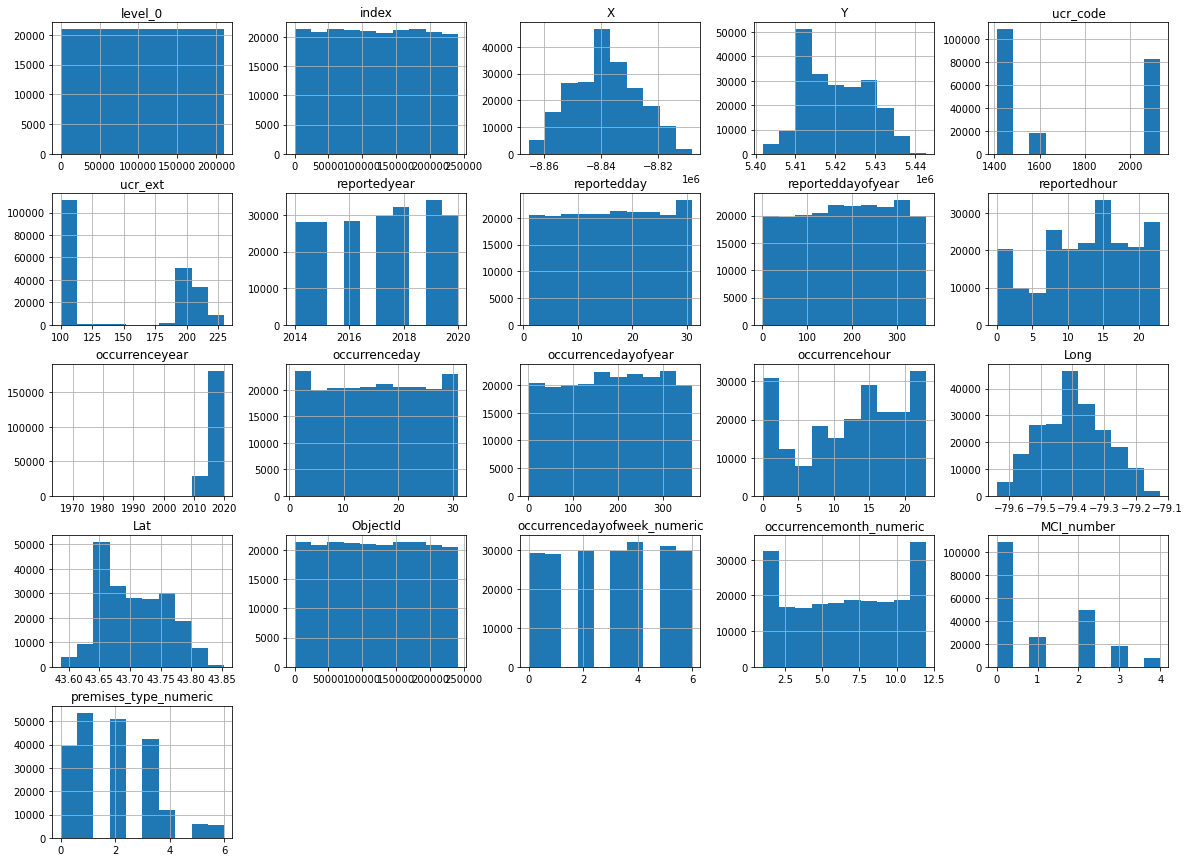

In [ ]:
unique_data.hist(figsize=(20,15))
plt.show()

# Scatter Plot

C:\Users\HomeKan\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Long', ylabel='Lat'>

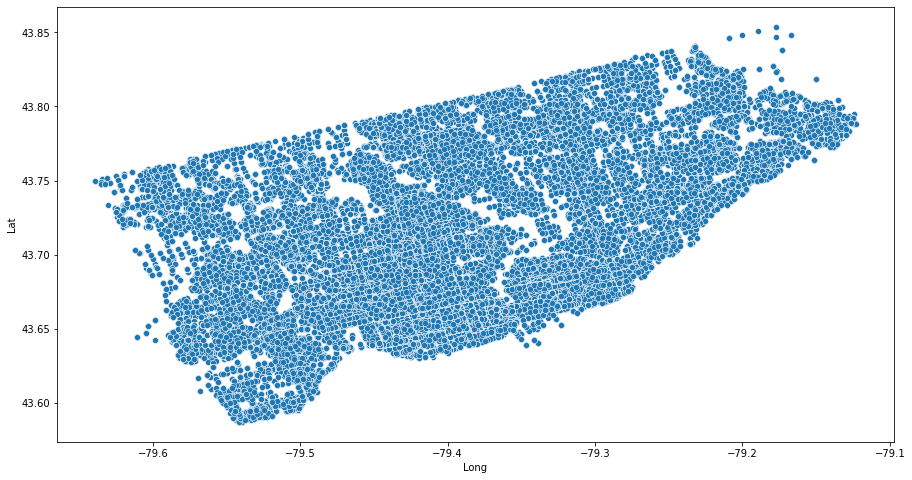

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (15,8))
sns.scatterplot(unique_data['Long'], unique_data['Lat'])


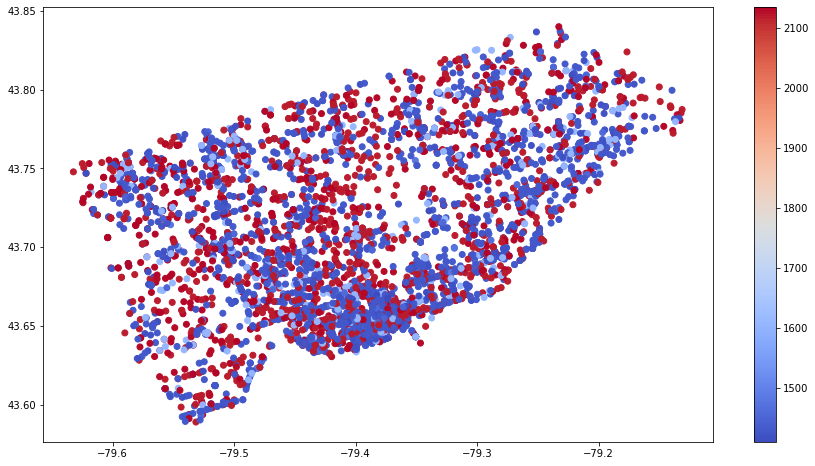

In [ ]:
# Visualize a sample using X and Y (lat, long) coordinates on a map of Toronto, the colours indicate the crime type (UCR - universal crime reference)

unique_data_random = unique_data.sample(n=5000)
plt.show()
plt.figure(figsize=(15, 8))
plt.scatter(unique_data_random["Long"], unique_data_random["Lat"], alpha=0.99, c=unique_data_random["ucr_code"], cmap='coolwarm', marker='o')
# plt.savefig('toronot crime map.png', dpi=200)
plt.colorbar()

# Bar graph of different columns/dimensions

<AxesSubplot:title={'center':'Neighbourhood'}, xlabel='Neighbourhood'>

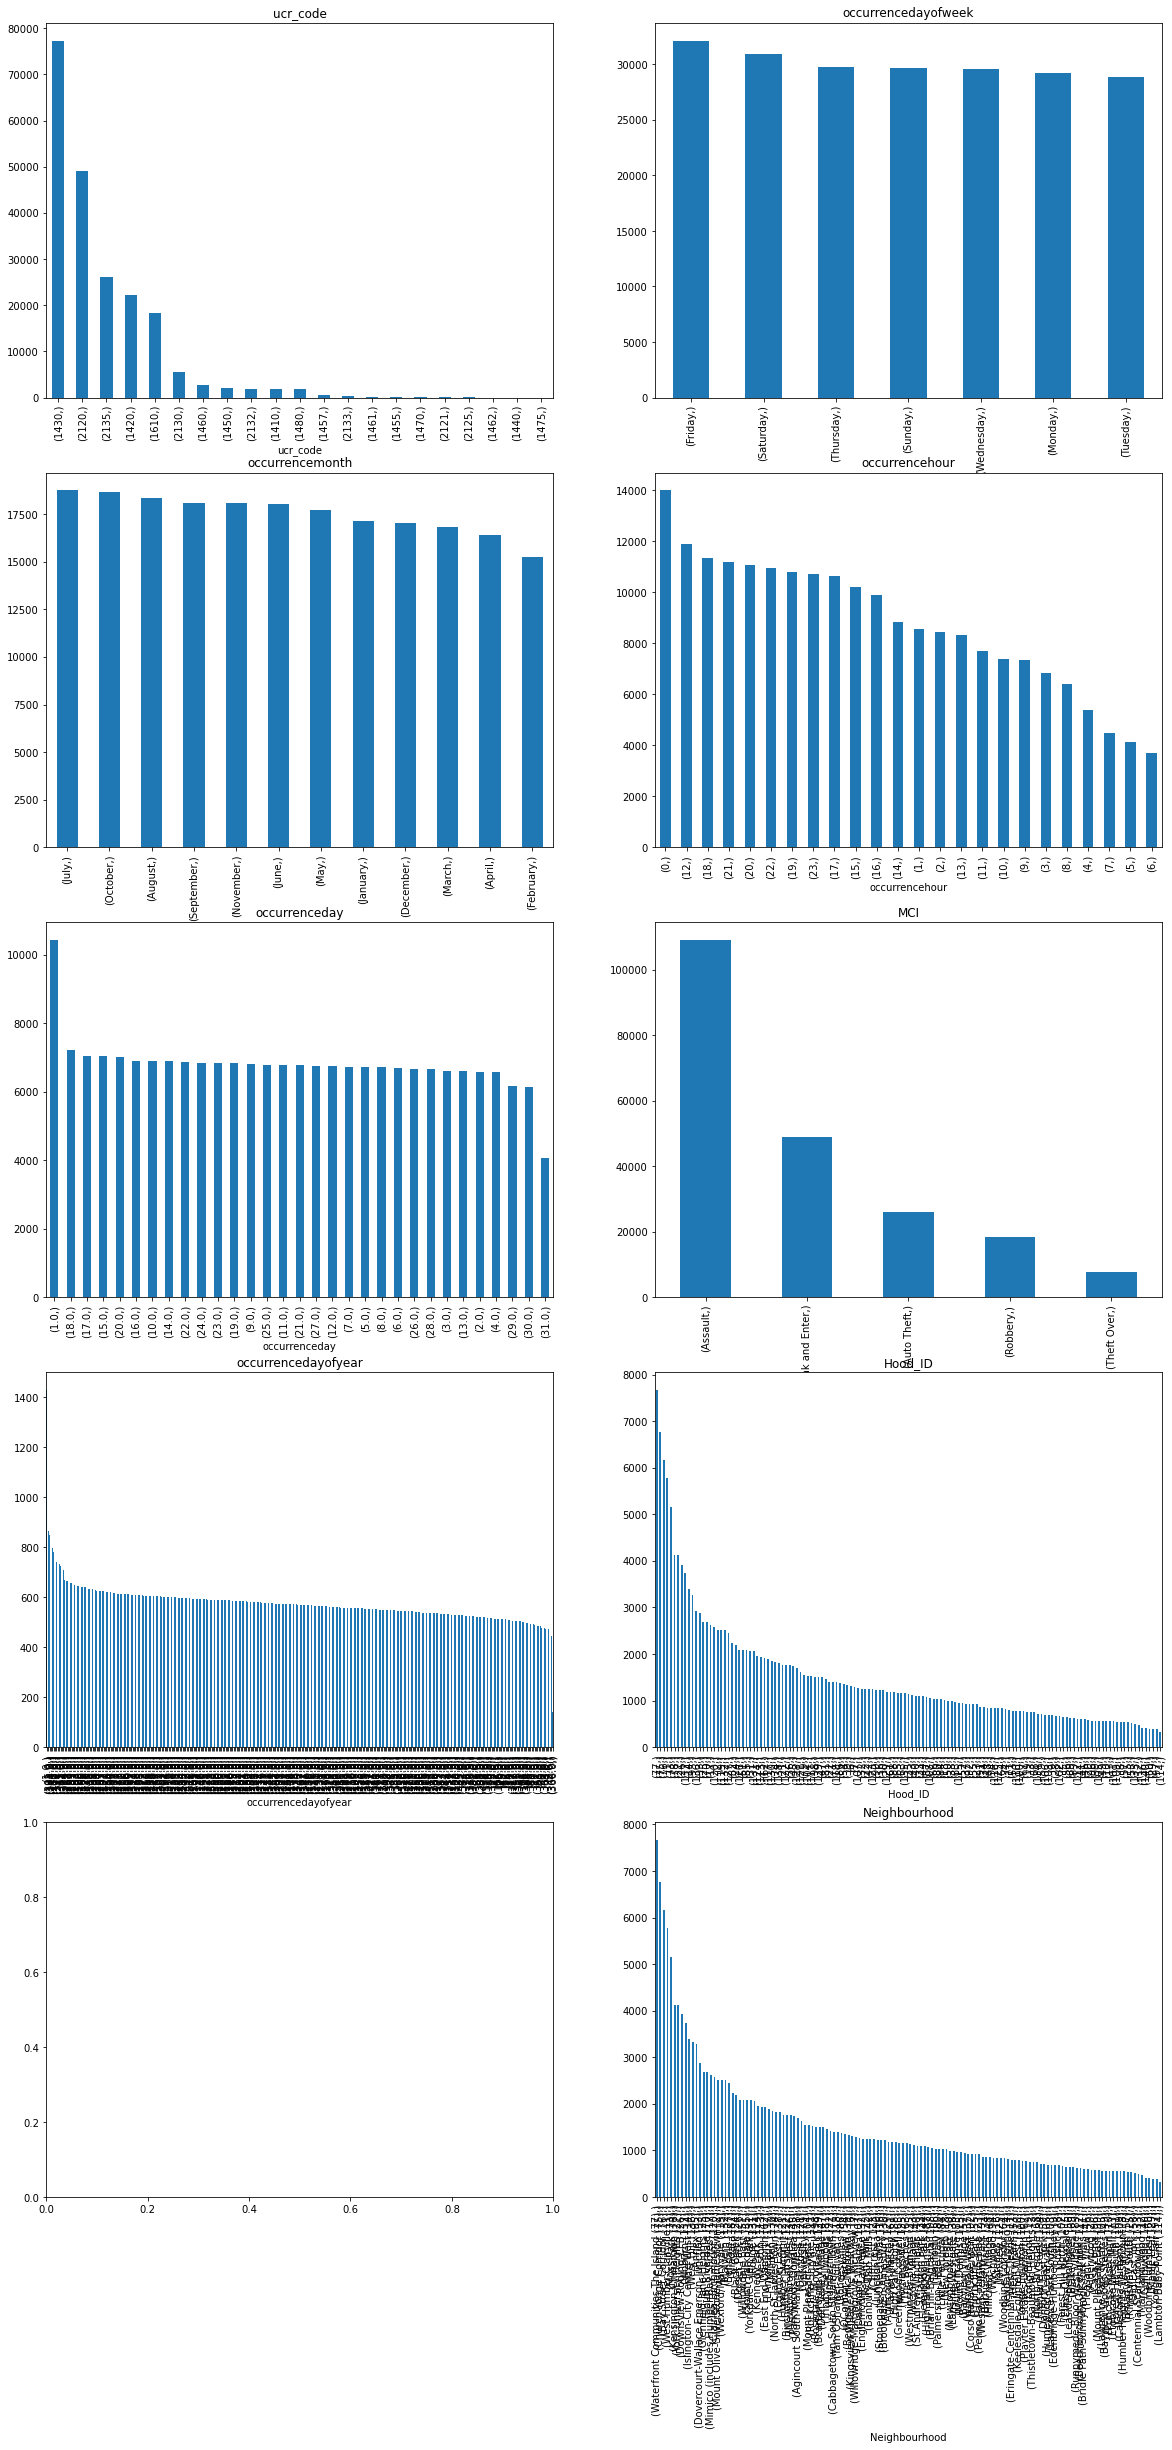

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20,40))
unique_data[["ucr_code"]].value_counts().plot.bar(ax=axes[0,0], title="ucr_code")
unique_data[["occurrencemonth"]].value_counts().plot.bar(ax=axes[1,0], title="occurrencemonth")
unique_data[["occurrenceday"]].value_counts().plot.bar(ax=axes[2,0], title="occurrenceday")
unique_data[["occurrencedayofyear"]].value_counts().plot.bar(ax=axes[3,0], title="occurrencedayofyear")
unique_data[["occurrencedayofweek"]].value_counts().plot.bar(ax=axes[0,1], title="occurrencedayofweek")
unique_data[["occurrencehour"]].value_counts().plot.bar(ax=axes[1,1], title="occurrencehour")
unique_data[["MCI"]].value_counts().plot.bar(ax=axes[2,1], title="MCI")
unique_data[["Hood_ID"]].value_counts().plot.bar(ax=axes[3,1], title="Hood_ID")
unique_data[["Neighbourhood"]].value_counts().plot.bar(ax=axes[4,1], title="Neighbourhood")
#plt.savefig('Depiction.png')

In [ ]:
unique_data.columns

Index(['level_0', 'index', 'X', 'Y', 'event_unique_id', 'Division',
       'occurrencedate', 'reporteddate', 'premises_type', 'ucr_code',
       'ucr_ext', 'offence', 'reportedyear', 'reportedmonth', 'reportedday',
       'reporteddayofyear', 'reporteddayofweek', 'reportedhour',
       'occurrenceyear', 'occurrencemonth', 'occurrenceday',
       'occurrencedayofyear', 'occurrencedayofweek', 'occurrencehour', 'MCI',
       'Hood_ID', 'Neighbourhood', 'Long', 'Lat', 'ObjectId',
       'occurrencedayofweek_numeric', 'occurrencemonth_numeric', 'MCI_number',
       'premises_type_numeric'],
      dtype='object')

In [ ]:
unique_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210350 entries, 0 to 210349
Data columns (total 34 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   level_0                      210350 non-null  int64  
 1   index                        210350 non-null  int64  
 2   X                            210350 non-null  float64
 3   Y                            210350 non-null  float64
 4   event_unique_id              210350 non-null  object 
 5   Division                     210350 non-null  object 
 6   occurrencedate               210350 non-null  object 
 7   reporteddate                 210350 non-null  object 
 8   premises_type                210350 non-null  object 
 9   ucr_code                     210350 non-null  int64  
 10  ucr_ext                      210350 non-null  int64  
 11  offence                      210350 non-null  object 
 12  reportedyear                 210350 non-null  int64  
 13 

## Objective 1

### Feature Engineering

In [ ]:
# Specify only relevant columns

columns = ["X", "Y", "premises_type", "occurrencemonth", "occurrenceday", "occurrencedayofyear", "occurrencedayofweek", "occurrencehour", "MCI", "Hood_ID", "Neighbourhood"]
unique_data_obj1 = unique_data[columns].copy()

In [ ]:
# Season variable
unique_data_obj1.loc[(unique_data_obj1['occurrencedayofyear'] >= 354) 
       |
       (unique_data_obj1['occurrencedayofyear'] <= 77)
       , 'Season'] = 'Winter'
#
unique_data_obj1.loc[(unique_data_obj1['occurrencedayofyear'] > 77) & (unique_data_obj1['occurrencedayofyear'] <= 170)
       , 'Season'] = 'Spring'
#
unique_data_obj1.loc[(unique_data_obj1['occurrencedayofyear'] >= 171) & (unique_data_obj1['occurrencedayofyear'] <= 264)
       , 'Season'] = 'Summer'
#
unique_data_obj1.loc[(unique_data_obj1['occurrencedayofyear'] >= 265) & (unique_data_obj1['occurrencedayofyear'] <= 353)
       , 'Season'] = 'Fall'

In [ ]:
# Weekday/weekend variable
unique_data_obj1.loc[(unique_data_obj1['occurrencedayofweek'] == 'Sunday') 
       |
       (unique_data_obj1['occurrencedayofweek'] == 'Saturday')
       , 'Weekday/Weekend'] = 'weekend'
#
unique_data_obj1.loc[(unique_data_obj1['occurrencedayofweek'] != 'Sunday') & (unique_data_obj1['occurrencedayofweek'] != 'Saturday')
       , 'Weekday/Weekend'] = 'weekday'

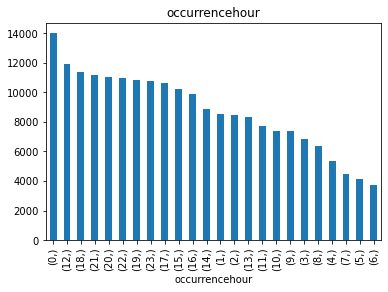

In [ ]:
# Group crime commission levels (low, medium, high, peak) according to time of day intervals:
unique_data_obj1[["occurrencehour"]].value_counts().plot.bar(title="occurrencehour")
# low: 4-6 am
# Medium: 1-3am & 8am-1pm 
# High 3pm-11pm, 1-2am
# Peak: 12am-1am
# Low
unique_data_obj1.loc[(unique_data_obj1['occurrencehour'] >= 4) & (unique_data_obj1['occurrencehour'] <= 7)
       , 'ToD Crime Level'] = 'low'

# Medium
unique_data_obj1.loc[(unique_data_obj1['occurrencehour'] >= 8) & (unique_data_obj1['occurrencehour'] <= 11) 
       |
       (unique_data_obj1['occurrencehour'] <= 3) & (unique_data_obj1['occurrencehour'] >= 1) 
       |
       (unique_data_obj1['occurrencehour'] >= 13) & (unique_data_obj1['occurrencehour'] <= 14)
       , 'ToD Crime Level'] = 'medium'

# High
unique_data_obj1.loc[(unique_data_obj1['occurrencehour'] >= 15) & (unique_data_obj1['occurrencehour'] <= 23) 
       | 
       (unique_data_obj1['occurrencehour'] == 12)
       , 'ToD Crime Level'] = 'high'

# Peak
unique_data_obj1.loc[(unique_data_obj1['occurrencehour'] == 0), 'ToD Crime Level'] = 'peak'

In [ ]:
# 1, 46, 92, 144, 182, 249, 284, 359, 360
# New year, family day, good friday, victoria day, canada day, labour day, thanksgiving, christmas, boxing day (Ontaio)
ontario_holiday = (1, 46, 92, 144, 182, 249, 284, 359, 360)
unique_data_obj1['Holiday/Non-Holiday'] = unique_data_obj1['occurrencedayofyear'].apply(lambda x: 'Holiday' if x in ontario_holiday else 'Non-Holiday')

In [ ]:
# Check for null values in engineered variables
unique_data_obj1.Season.isna().sum(), unique_data_obj1.Season.value_counts().sum()
unique_data_obj1["Weekday/Weekend"].isna().sum(), unique_data_obj1["Weekday/Weekend"].value_counts().sum()
unique_data_obj1["ToD Crime Level"].isna().sum(), unique_data_obj1["ToD Crime Level"].value_counts().sum()
unique_data_obj1["Holiday/Non-Holiday"].isna().sum(), unique_data_obj1["Holiday/Non-Holiday"].value_counts().sum()

(0, 210350)

In [ ]:
unique_data_obj1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210350 entries, 0 to 210349
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   X                    210350 non-null  float64
 1   Y                    210350 non-null  float64
 2   premises_type        210350 non-null  object 
 3   occurrencemonth      210292 non-null  object 
 4   occurrenceday        210350 non-null  float64
 5   occurrencedayofyear  210350 non-null  float64
 6   occurrencedayofweek  210292 non-null  object 
 7   occurrencehour       210350 non-null  int64  
 8   MCI                  210350 non-null  object 
 9   Hood_ID              210350 non-null  object 
 10  Neighbourhood        210350 non-null  object 
 11  Season               210350 non-null  object 
 12  Weekday/Weekend      210350 non-null  object 
 13  ToD Crime Level      210350 non-null  object 
 14  Holiday/Non-Holiday  210350 non-null  object 
dtypes: float64(4), in

In [ ]:
unique_data_obj1.head(3)

,X,Y,premises_type,occurrencemonth,occurrenceday,occurrencedayofyear,occurrencedayofweek,occurrencehour,MCI,Hood_ID,Neighbourhood,Season,Weekday/Weekend,ToD Crime Level,Holiday/Non-Holiday
0,-8.859749e+06,5.423033e+06,House,May,18.0,138.0,Sunday,12,Assault,1,West Humber-Clairville (1),Spring,weekend,high,Non-Holiday
1,-8.861050e+06,5.426864e+06,Outside,May,19.0,139.0,Monday,20,Assault,1,West Humber-Clairville (1),Spring,weekday,high,Non-Holiday
2,-8.861412e+06,5.422084e+06,Apartment,May,19.0,139.0,Monday,22,Break and Enter,1,West Humber-Clairville (1),Spring,weekday,high,Non-Holiday


## Encoding

In [ ]:
# a single command to get all the dummies does not work well, hence I put dummies in different variables
ohe_dummies_set = pd.get_dummies(unique_data_obj1[['premises_type', 'occurrencemonth', 'MCI', 'Hood_ID', 'Neighbourhood']])
dummy_1 = pd.get_dummies(unique_data_obj1['Holiday/Non-Holiday']) # engineered features
dummy_2 = pd.get_dummies(unique_data_obj1['ToD Crime Level']) # engineered features
dummy_3 = pd.get_dummies(unique_data_obj1['Weekday/Weekend']) # engineered features
dummy_4 = pd.get_dummies(unique_data_obj1['Season']) # engineered features
dummy_5 = pd.get_dummies(unique_data_obj1['occurrencedayofweek']) # these need to be encoded so as to not have an incremental effect on target variable; each day of week is unique
dummy_6 = pd.get_dummies(unique_data_obj1['occurrencedayofyear']) # these need to be encoded so as to not have an incremental effect on target variable; each day of year is unique
dummy_7 = pd.get_dummies(unique_data_obj1['occurrencehour']) # these need to be encoded so as to not have an incremental effect on target variable; each hour is unique

In [ ]:
# drop original variables to do away with multicollinearity
unique_data_obj1= unique_data_obj1.drop(['premises_type', 'occurrencemonth', 'occurrenceday',
       'occurrencedayofyear', 'occurrencedayofweek', 'occurrencehour', 'MCI',
       'Hood_ID', 'Neighbourhood', 'Season', 'Weekday/Weekend',
       'ToD Crime Level', 'Holiday/Non-Holiday'], axis=1)

In [ ]:
# put all dummies and X, Y in one DataFrame
unique_data_obj1 = pd.concat((unique_data_obj1, ohe_dummies_set, dummy_1, dummy_2, dummy_3, dummy_4, dummy_5, dummy_6, dummy_7), axis=1, ignore_index=True)
unique_data_obj1.rename(columns = {0:'X', 1:'Y'}, inplace = True)

In [ ]:
unique_data_obj1.head(3)

,X,Y,2,3,4,5,6,7,8,9,...,706,707,708,709,710,711,712,713,714,715
0,-8.859749e+06,5.423033e+06,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-8.861050e+06,5.426864e+06,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2,-8.861412e+06,5.422084e+06,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


## Model

In [ ]:
from sklearn.model_selection import train_test_split

y = unique_data_obj1[["X","Y"]]
X = unique_data_obj1.drop(columns=['X', 'Y'])

# split dataset into training dataset and testing dataset
# test dataset = 30%, shuffle = True since it's not time-series
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size =0.3, shuffle = True,random_state =42)

In [ ]:
# create empty lists of rmse, means and standardiaviation of Euclidean distance, and regressor name
result_rmse =[]
result_elu_mean =[]
result_elu_std =[]
result_best_score = []
result_elapsed_time = []
reg_name =[]

### 1. Linear Regressor

In [ ]:
import time
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

linr_start = time.time() # keep start time to compute elapsed time

#create pipeline
linr_pipe = Pipeline([('select', PCA()),
                    ('linr', LinearRegression())])

# set parameters for GridSearch
linr_params = {
             'select__n_components':[.90,.95],
             'linr__fit_intercept':[True,False], 
             'linr__normalize':[True,False]
            }

# run GridSearchCV to find the best setting of parameters  
linr_reg = GridSearchCV(linr_pipe, linr_params, scoring='neg_mean_squared_error',
                        n_jobs=2, refit=True, cv=3, verbose=True, return_train_score=True)

#train the model
linr_reg.fit(X_train,y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  24 out of  24 | elapsed:  2.2min finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('select', PCA()),
                                       ('linr', LinearRegression())]),
             n_jobs=2,
             param_grid={'linr__fit_intercept': [True, False],
                         'linr__normalize': [True, False],
                         'select__n_components': [0.9, 0.95]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=True)

In [ ]:
# show  parameters of the best model for linear regressor
print('Best Score of Linear Regressor: ',linr_reg.best_params_) 

# compute elapsed time
linr_end = time.time() 
linr_elapsed_time = linr_end - linr_start  

{'linr__fit_intercept': True,
 'linr__normalize': True,
 'select__n_components': 0.95}

In [ ]:
# create a function to calculate rmse, mean of errors and standard deviation of errors
def cal_rmse_mean_std_error (y_test, y_predit):
    "get two datasets of y_test and y_predict (shape of input is (xxx,2))"
    "calculate euclidean distance, means of distance errors, and std of distance errors"
    "Then, return these values"
    #compute root mean squared error of predictions
    rmse = np.sqrt(mean_squared_error(y_test, y_predit))
    
    # compute meand and std of euclidean distance 
    euclidean_dist = ((y_test - y_predit)['X']**2 + (y_test - y_predit)['X']**2)**0.5
    mean_error = euclidean_dist.mean()
    std_error = euclidean_dist.std()
    
    return rmse, mean_error, std_error

In [ ]:
from sklearn.metrics import mean_squared_error

# prdict lat and long for X_trian
linr_y_tr_pred = linr_reg.predict(X_train)
linr_tr_rmse =(mean_squared_error(linr_y_tr_pred,y_train))**0.5
print('Training Data: Linear RMSE:{:.2f}'.format(linr_tr_rmse)) # show RMSE of training data

# predict lat and long
linr_y_pred = linr_reg.predict(X_test)

#compute rmse, mean of distance errors, and standard deviation of distance errors 
linr_rmse, linr_dist_mean_error, linr_dist_std =  cal_rmse_mean_std_error (y_test, linr_y_pred)

print('Testing Data: Linear RMSE {:.2f}'.format(linr_rmse),'Mean errors of Euclidean Distance: {:.2f}'.format(linr_dist_mean_error),
      'Standard deviation of Euclidean Distance: {:.2f}'.format(linr_dist_std))

Training Data: Linear RMSE:1087.81
Testing Data: Linear RMSE 1086.87 Mean errors of Euclidean Distance: 1136.17 Standard deviation of Euclidean Distance: 1035.09


RMSE of testing data is insignificantly different from RMFE of trainin data, meaning that this model is not overfitting

In [ ]:
# keep reg_name, rmse, mean and std of Euclidean_dist, best score, and elapsed time for further analysis
reg_name.append('Linear')
result_rmse.append(linr_rmse)
result_elu_mean.append(linr_dist_mean_error)
result_elu_std.append(linr_dist_std)
result_elapsed_time.append(linr_elapsed_time/60) #convert sec to min

### 2. Elastic Net Regressor

In [ ]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import ElasticNet

EN_start = time.time() # keep start time to cumpute elapsed time

# construct a pipeline
EN_pipe = Pipeline([('select', PCA()),
                    ('EN', MultiOutputRegressor(ElasticNet()))])

# set parameters for GridSearch
EN_params = {
              'select__n_components':[.90,.95],
              'EN__estimator__alpha':np.logspace(0,3, num=4),
              'EN__estimator__l1_ratio':[0,0.4,0.8,1.0],
              'EN__estimator__fit_intercept': [True,False],
              'EN__estimator__normalize':[True,False]
             }

# run GridSearchCV to find the best setting of parameters    
EN_reg = GridSearchCV(EN_pipe, EN_params,  scoring='neg_mean_squared_error',
                      n_jobs=2, refit=True, cv=3, verbose=True, return_train_score=True)
#train the model
EN_reg.fit(X_train,y_train)

Fitting 3 folds for each of 128 candidates, totalling 384 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed: 11.3min
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed: 48.3min
[Parallel(n_jobs=2)]: Done 384 out of 384 | elapsed: 89.2min finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('select', PCA()),
                                       ('EN',
                                        MultiOutputRegressor(estimator=ElasticNet()))]),
             n_jobs=2,
             param_grid={'EN__estimator__alpha': array([   1.,   10.,  100., 1000.]),
                         'EN__estimator__fit_intercept': [True, False],
                         'EN__estimator__l1_ratio': [0, 0.4, 0.8, 1.0],
                         'EN__estimator__normalize': [True, False],
                         'select__n_components': [0.9, 0.95]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=True)

In [ ]:
# show  parameters of the best model for EN regressor
print('Best Score of Elastic Net Regressor: ',EN_reg.best_params_) 

# calculate elapsed time
EN_end = time.time() 
EN_elapsed_time = EN_end - EN_start  

{'EN__estimator__alpha': 1.0,
 'EN__estimator__fit_intercept': True,
 'EN__estimator__l1_ratio': 1.0,
 'EN__estimator__normalize': False,
 'select__n_components': 0.95}

In [ ]:
# prdict lat and long for X_trian
EN_y_tr_pred = EN_reg.predict(X_train)
EN_tr_rmse =(mean_squared_error(EN_y_tr_pred,y_train))**0.5
print('Training Data: Elastic Net RMSE:{:.2f}'.format(EN_tr_rmse)) # show RMSE of training data

EN_y_pred = EN_reg.predict(X_test) # predict lat and long

#compute rmse, mean of distance errors, and standard deviation of distance errors 
EN_rmse, EN_dist_mean_error, EN_dist_std =  cal_rmse_mean_std_error (y_test, EN_y_pred)

#show results
print('Testing Data: Elastic Net RMSE: {:.2f}'.format(EN_rmse),'Mean errors of Euclidean Distance: {:.2f}'.format(EN_dist_mean_error),
      'Standard deviation of Euclidean Distance: {:.2f}'.format(EN_dist_std))

Training Data: Elastic Net RMSE:1111.61
Testing Data: Elastic Net RMSE: 1111.77 Mean errors of Euclidean Distance: 1160.79 Standard deviation of Euclidean Distance: 1071.73


In [ ]:
# keep reg_name, rmse, mean and std of Euclidean_dist, best score, and elapsed time for further analysis
reg_name.append('Elastic Net') 
result_rmse.append(EN_rmse)
result_elu_mean.append(EN_dist_mean_error)
result_elu_std.append(EN_dist_std)
result_elapsed_time.append(EN_elapsed_time/60) #convert sec to min

### 3. XGB Regressor

In [ ]:
from xgboost.sklearn import XGBRegressor

XGB_start = time.time() # keep start time to cumpute elapsed time

# construct a pipeline
XGB_pipe = Pipeline([('select', PCA()),
                    ('XGB', MultiOutputRegressor(XGBRegressor(tree_method='gpu_hist', 
                      gpu_id=0,objective='reg:linear',nthread=4,predictor='gpu_predictor')))])


# set parameters for GridSearch
XGB_params = {
              'select__n_components':[.90,.95],
              'XGB__estimator__learning_rate': [0.05, 0.1, 0.4, 0.7], #so called `eta` value
              'XGB__estimator__max_depth': [2, 3, 4, 5],
              'XGB__estimator__n_estimators': [400,600,800]
             }

# run GridSearch to find the best  parameters    
XGB_reg = GridSearchCV(XGB_pipe, XGB_params,  scoring='neg_mean_squared_error',
                      n_jobs=2, refit=True, cv=3, verbose=True, return_train_score=True)
# train the model
XGB_reg.fit(X_train,y_train)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed: 15.3min
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed: 79.2min
[Parallel(n_jobs=2)]: Done 288 out of 288 | elapsed: 126.5min finished


[10:19:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[10:20:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('select', PCA()),
                                       ('XGB',
                                        MultiOutputRegressor(estimator=XGBRegressor(base_score=None,
                                                                                    booster=None,
                                                                                    colsample_bylevel=None,
                                                                                    colsample_bynode=None,
                                                                                    colsample_bytree=None,
                                                                                    gamma=None,
                                                                                    gpu_id=0,
                                                                                    importance_type='gain',
                                                         

In [ ]:
# show  parameters of the best model for XGB regressor
print('Best Score of XGB Regressor: ', XGB_reg.best_params_ ) 

# calculate elapsed time
XGB_end = time.time() 
XGB_elapsed_time = XGB_end - XGB_start 

{'XGB__estimator__learning_rate': 0.1,
 'XGB__estimator__max_depth': 5,
 'XGB__estimator__n_estimators': 800,
 'XGB__estimator__predictor': 'gpu_predictor',
 'select__n_components': 0.9}

In [ ]:
# prdict lat and long for X_trian
XGB_y_tr_pred = XGB_reg.predict(X_train)
XGB_tr_rmse =(mean_squared_error(XGB_y_tr_pred,y_train))**0.5

print('Training Data: XGB RMSE{:.2f}'.format(XGB_tr_rmse)) # show RMSE of training data

# predict lat and long
XGB_y_pred = XGB_reg.predict(X_test)

#compute rmse, mean of distance errors, and standard deviation of distance errors 
XGB_rmse, XGB_dist_mean_error, XGB_dist_std =  cal_rmse_mean_std_error (y_test, XGB_y_pred)

#show results
print('Testing Data: XGB RMSE {:.2f}'.format(XGB_rmse),'Mean errors of Euclidean Distance: {:.2f}'.format(XGB_dist_mean_error),
      'Standard deviation of Euclidean Distance: {:.2f}'.format(XGB_dist_std))

Training Data: XGB RMSE990.79
Testing Data: XGB RMSE 1101.80 Mean errors of Euclidean Distance: 1135.40 Standard deviation of Euclidean Distance: 1064.76


In [ ]:
# keep reg_name, rmse, mean and std of Euclidean_dist for further analysis
reg_name.append('XGB') 
result_rmse.append(XGB_rmse)
result_elu_mean.append(XGB_dist_mean_error)
result_elu_std.append(XGB_dist_std)
result_elapsed_time.append(XGB_elapsed_time/60) #convert sec to min

### 4. Voting Regressor 

In [ ]:
from sklearn.ensemble import VotingRegressor

VR_bm_start = time.time() # keep start time to cumpute elapsed time

# create best models manually: linear, Elastic Net, XGB
lr_best = LinearRegression(fit_intercept=True,normalize=True) 

EN_best = ElasticNet(alpha=1.0,fit_intercept=True,l1_ratio=1.0,normalize=False)

XGB_best = XGBRegressor(learning_rate=0.1,max_depth=5,n_estimators=800,nthread=4,
                       objective='reg:squarederror',predictor='gpu_predictor',tree_method='gpu_hist', gpu_id=0)

#Apply PCA =0.95 to X since 2 of 3 models get the better results when PCA = 0.95
## Assume PCE = 0.95 for Voting Regressor
pca = PCA(n_components=0.95, svd_solver='full') # let PCA find the number of features which explained_variance_ratio_ =0.95
pca.fit(X)
X_95 = pca.transform(X)
df_X_95 = pd.DataFrame(X_95)


# test dataset = 30%, shuffle = True since it's not time-series
## neeed to split X and y again so that the number of features of X_train is equal to that of X_test
X_train_95, X_test_95, y_train_95, y_test_95 = train_test_split(df_X_95,y,test_size =0.3, shuffle = True,random_state =42)


# combine the three models: linear, Elastic Net, XGB to constract voting regressor
VR_bm_reg = MultiOutputRegressor(VotingRegressor(estimators=[('lr', lr_best), ('EN', EN_best), ('XGB', XGB_best)]))

# fit data
VR_bm_reg.fit(X_train_95,y_train)

MultiOutputRegressor(estimator=VotingRegressor(estimators=[('lr',
                                                            LinearRegression(normalize=True)),
                                                           ('EN',
                                                            ElasticNet(l1_ratio=1.0)),
                                                           ('XGB',
                                                            XGBRegressor(base_score=None,
                                                                         booster=None,
                                                                         colsample_bylevel=None,
                                                                         colsample_bynode=None,
                                                                         colsample_bytree=None,
                                                                         gamma=None,
                                                                    

In [ ]:
# calculate elapsed time
VR_bm_end = time.time() 
VR_bm_elapsed_time = VR_bm_end - VR_bm_start 

In [ ]:
# prdict lat and long for X_trian
VR_bm_y_tr_pred = VR_bm_reg.predict(X_train_95)
VR_bm_tr_rmse =(mean_squared_error(VR_bm_y_tr_pred,y_train))**0.5

print('Training Data: VR RMSE:{:.2f}'.format(VR_bm_tr_rmse)) # show RMSE of training data

# predict lat and long
VR_bm_y_pred = VR_bm_reg.predict(X_test_95)

#compute rmse, mean of distance errors, and standard deviation of distance errors 
VR_bm_rmse, VR_bm_dist_mean_error, VR_bm_dist_std =  cal_rmse_mean_std_error (y_test, VR_bm_y_pred)

#show results
print('Testing Data: VR RMSE: {:.2f}'.format(VR_bm_rmse),'Mean errors of Euclidean Distance: {:.2f}'.format(VR_bm_dist_mean_error),
      'Standard deviation of Euclidean Distance: {:.2f}'.format(VR_bm_dist_std))

Training Data: VR RMSE:1021.86
Testing Data: VR RMSE: 1057.32 Mean errors of Euclidean Distance: 1094.61 Standard deviation of Euclidean Distance: 1007.38


In [ ]:
# keep reg_name, rmse, mean and std of Euclidean_dist for further analysis
reg_name.append('Voting') 
result_rmse.append(VR_bm_rmse)
result_elu_mean.append(VR_bm_dist_mean_error)
result_elu_std.append(VR_bm_dist_std)


# we run grid search to find the best parameters and then using the best parameters to create models, so we should include
## elpased time for training three models
VR_elapsed_time_total =  linr_elapsed_time + EN_elapsed_time + XGB_elapsed_time + VR_bm_elapsed_time

result_elapsed_time.append(VR_elapsed_time_total/60) #convert sec to min

### Results

In [ ]:
# create dataframe to show result
result = pd.DataFrame(list(zip(reg_name, result_rmse,result_elu_mean,result_elu_std,result_elapsed_time)),
               columns =['Regressor Name', 'RMSE','Mean Error','SD','Elapsed Time (min)'])

result=result.round(1) # round values to be 1 decimal
result.head()

,Regressor Name,RMSE,Mean Error,SD,Elapsed Time (min)
0,Linear,1086.9,1136.2,1035.1,2.4
1,Elastic Net,1111.8,1160.8,1071.7,89.4
2,XGB,1101.8,1135.4,1064.8,127.3
3,Voting,1057.3,1094.6,1007.4,220.5


Text(0.5, 0, 'Regressor Name')

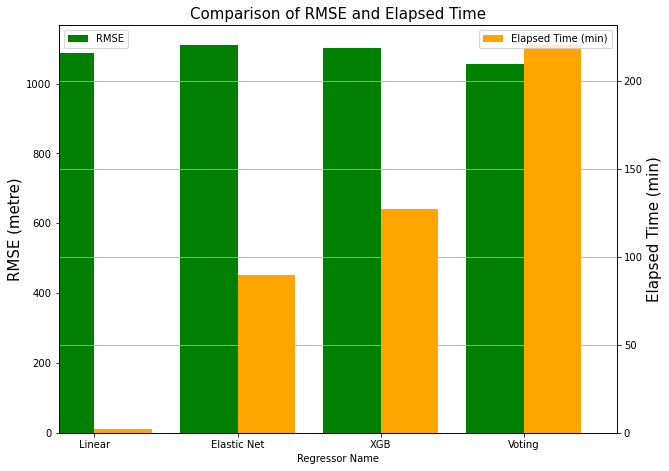

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

# plot RMSE and Elapsed Time
ax = result.plot(x='Regressor Name',y='RMSE',kind='bar',figsize=(10,7.5), color='green', ax=ax, width=0.4 ,position=1,rot =0,fontsize =10)
ax2 = result.plot(x='Regressor Name',y='Elapsed Time (min)',kind='bar',figsize=(10,7.5), color='orange'
                  , ax=ax2, width=0.4, position=0,rot=0,fontsize =10)

ax.set_ylabel('RMSE (metre)', fontsize = 15)
ax2.set_ylabel('Elapsed Time (min)', fontsize = 15)

ax.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.grid()
plt.title('Comparison of RMSE and Elapsed Time', fontsize = 15)
plt.xlabel('Regressor Name',fontsize =15)

<ErrorbarContainer object of 3 artists>

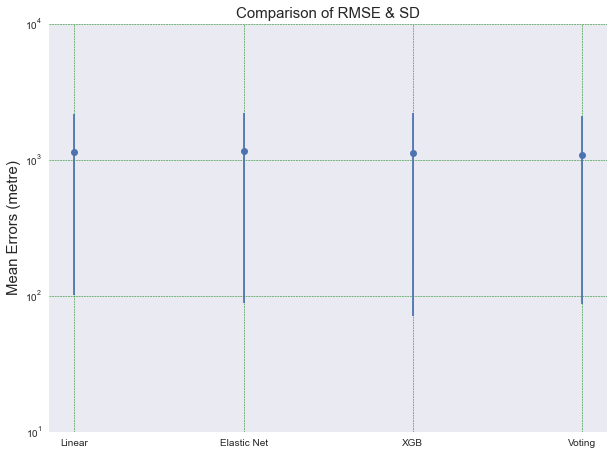

In [ ]:
#show mean errors with std
fig = plt.figure(figsize=(10,7.5))

plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)
plt.yscale('log')
plt.ylim(10, 10**4)
plt.ylabel ('Mean Errors (metre)', fontsize = 15)
plt.title('Comparison of RMSE & SD', fontsize = 15)
plt.errorbar(result['Regressor Name'],result['Mean Error'], result['SD'], linestyle='None', marker='o')

## Prediction


In [ ]:
# choose data we want to predict X and Y from event_unique_id
df_predict = unique_data.query('event_unique_id in ["GO-20161131520","GO-20201286477","GO-2017318380","GO-2015221810","GO-20191249125","GO-20202246163"]')
df_predict[['X','Y','event_unique_id']]

# according to this table, list of index = [31633,33219,34336,113462,117692,119444]

,X,Y,event_unique_id
31633,-8.851696e+06,5.428352e+06,GO-20161131520
33219,-8.852404e+06,5.429531e+06,GO-20201286477
34336,-8.851579e+06,5.426388e+06,GO-2017318380
113462,-8.837708e+06,5.410670e+06,GO-2015221810
117692,-8.839123e+06,5.410698e+06,GO-20191249125
119444,-8.838855e+06,5.410561e+06,GO-20202246163


In [ ]:
list_idx = [31633,33219,34336,113462,117692,119444] # list of index for predicting X and Y

list_reg = [VR_bm_reg] # regressor to predict X and Y
reg_name = ['Voting'] # regressor name to predict X and Y
result = np.zeros((len(list_idx),len(list_reg))).astype('str') # create string array to keep predictions

for a, reg in enumerate(list_reg):

    for b, idx in enumerate(list_idx):
        if (reg==VR_bm_reg):
            temp_df =pd.DataFrame(df_X_95.iloc[idx,:]).transpose()
        else:
            temp_df =pd.DataFrame(X.iloc[idx,:]).transpose()
            
        temp_y_pred = reg.predict(temp_df).round(0) # predict X,Y and then round to 0 decimal
        result[b,a]= str(temp_y_pred[0]) # keep prediction in string array

df_result = pd.DataFrame(result, columns=reg_name, index=list_idx) # create result dataframe
df_result

,Voting
31633,[-8852102. 5429018.]
33219,[-8851963. 5429034.]
34336,[-8851465. 5426384.]
113462,[-8837676. 5410392.]
117692,[-8837438. 5410548.]
119444,[-8837277. 5410602.]


## Learning Curves

In [ ]:
# Considering learning curves are not part of the model and parameters to be exported, 
# they are visualized independent of the pipeline to be exported

from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

def plot_learning_curve(X_data, y_data, estimator, y_lim_up, y_lim_down, train_sizes, title: str):
    """
    Plots a learning curve given assumptions: PCA maintains 95% variance, train-test split 70:30, CV Folds =3, scoring: negative RMSE
    """
    # PCA
    pca = PCA(n_components=0.95, svd_solver='full') # let PCA find the numbe of features which explained_variance_ratio_ =0.95
    pca.fit(X_data)
    X_95 = pca.transform(X_data)

    # Train-tst split
    X_train, X_test, y_train, y_test = train_test_split(X_95, y_data,test_size =0.3, shuffle = True,random_state =42)
    
    # Train/Validate
    train_sizes, train_scores, validation_scores = learning_curve(estimator=estimator,
                                                                  X = X_train,
                                                                  y = y_train, train_sizes = train_sizes, cv = 3,
                                                                  scoring = 'neg_root_mean_squared_error')

    train_scores_mean = -train_scores.mean(axis = 1)
    validation_scores_mean = -validation_scores.mean(axis = 1)
    # Plot
    plt.style.use('seaborn')
    plt.plot(train_sizes, train_scores_mean, label = 'Training Curve')
    plt.plot(train_sizes, validation_scores_mean, label = 'Validation Curve')
    plt.ylabel('RMSE', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    plt.title('{}'.format(title), fontsize = 18, y = 1.03)
    plt.legend()
    plt.ylim(y_lim_down, y_lim_up)

In [ ]:
train_sizes = [1000, 2000, 4000, 7000, 10000, 20000, 4000, 60000, 90000]
y_lim_down = 600
y_lim_up = 2000

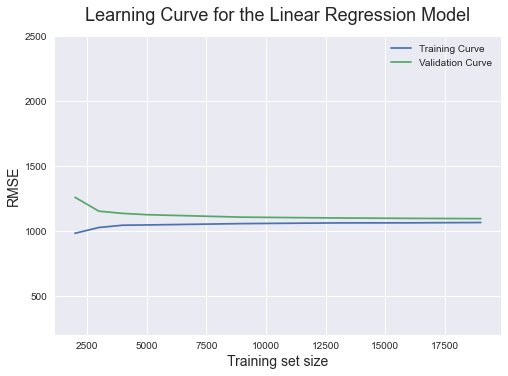

In [ ]:
# Learning Curve for the Linear Regression Model
LinReg =lr_best
plot_learning_curve(X, y, LinReg, y_lim_up, y_lim_down, train_sizes, "Learning Curve for the Linear Regression Model")

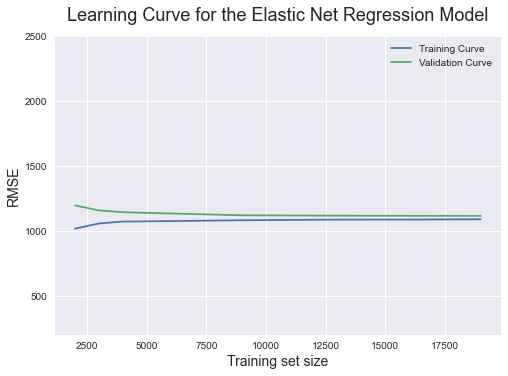

In [ ]:
# Learning Curve for the Elastic Net Regression Model
EL_net = EN_best
plot_learning_curve(X, y, EL_net, y_lim_up, y_lim_down, train_sizes, "Learning Curve for the Elastic Net Regression Model")

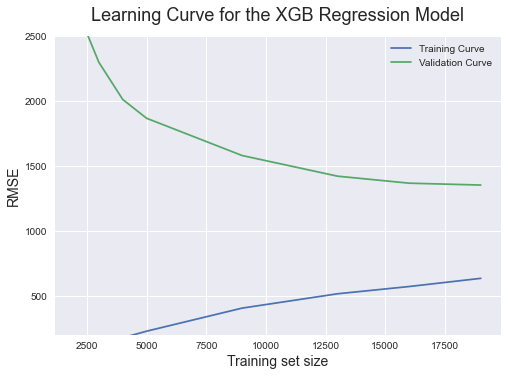

In [ ]:
# Learning Curve for the XGB Regression Model"

## create XGB regressor with best parameters from hyperparameter-tuning
XGB_best = MultiOutputRegressor(XGBRegressor(learning_rate=0.1,max_depth=5,n_estimators=800,nthread=4,
                       objective='reg:squarederror',predictor='gpu_predictor',tree_method='gpu_hist', gpu_id=0))

train_sets = [2000, 3000, 4000, 5000, 9000, 13000, 16000, 19000]
XGB_reg = XGB_best
y_lim_up = 2500
y_lim_down = 200
train_sizes=train_sets
plot_learning_curve(X, y, XGB_reg,y_lim_up, y_lim_down, train_sizes,"Learning Curve for the XGB Regression Model")

# Objective 2

## Models

### Decision Tree Classifier

HYPERPARAMETER TUNING - most of these we use the defaults but they are explicitly stated for clarity
https://towardsdatascience.com/how-to-tune-a-decision-tree-f03721801680

criterion='gini'
According to the paper “Theoretical comparison between the Gini Index and Information Gain criteria” [3], the frequency of agreement/disagreement of the Gini Index and the Information Gain was only 2% of all cases, so for all intents and purposes you can pretty much use either, but the only difference is entropy might be a little slower to compute because it requires you to compute a logarithmic function

splitter='best'
selecting 'random' gave a lower accuracy score and we don't need the computational advantages of not having to compute optimal split 'random' will have the advantage of being less prone to overfitting

max_depth=None
Again our dataset is small enough that we don't need optimize compute power so we will let the algorithm expand nodes until all leaves are pure or until all leaves contain less than min_samples_split samples In general, the deeper you allow your tree to grow, the more complex your model will become because you will have more splits and it captures more information about the data and this is one of the root causes of overfitting in decision trees because your model will fit perfectly for the training data and will not be able to generalize well on test set. So, if your model is overfitting, reducing the number for max_depth is one way to combat overfitting. Right now 20 gives same results as None

min_samples_split = 2
minimum number of samples required to split an internal node

ccp_alpha = 0.0
Complexity parameter used for Minimal Cost-Complexity Pruning. You would prune to avoid over-fitting The subtree with the largest cost complexity that is smaller than ccp_alpha will be chosen. By default, no pruning is performed (default = 0.0) The pruning process stops when the pruned tree’s complexity parameter alpha is greater than the ccp_alpha parameter unfortunately when applying pruning the accuracy_score dropped by about 5 random_state to be a number to get deterministic behaviour class weights as the decision tree does not perform well in an imbalanced dataset

we should apply custom weights (TODO) - 1430 ucr_code right now is about 30% of the dataset
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

In [ ]:
def run_decision_tree_classifier_grid_search(data):
    from sklearn.model_selection import StratifiedShuffleSplit
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.metrics import f1_score
    from sklearn.metrics import accuracy_score
    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import train_test_split

    columns = ['Lat', 
              'Long', 
              'occurrencedayofyear', 
              'occurrencedayofweek_numeric', 
              'occurrencehour', 
              'Hood_ID', 
              'premises_type_numeric']

    # 1475 has 1 instance, and we required 5 instance in minimum for SSS
    data = data.drop(unique_data[unique_data['ucr_code'] == 1475].index)

    X = data[columns].copy()
    y = data['ucr_code'].copy()
    sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

    tree_params = {
        'criterion':['gini'],
        'max_depth':[4, 8, 12, 16, None], 
        'splitter':['best', 'random'], 
        'ccp_alpha':[0, 0.5, 1], 
        'random_state': [42],
        'class_weight': ['balanced', None]
    }
    
    tree_clf = GridSearchCV(DecisionTreeClassifier(), tree_params, cv=3)

    for train_index, test_index in sss.split(X, y):
        X_stratified_train, X_stratified_test = X.iloc[train_index], X.iloc[test_index]
        y_stratified_train, y_stratified_test = y.iloc[train_index], y.iloc[test_index]

        tree_clf.fit(X_stratified_train, y_stratified_train)
        pred = tree_clf.predict(X_stratified_test)
        
        print("Best Params: ", tree_clf.best_params_)
        print("Accuracy Score: ", accuracy_score(y_stratified_test, pred))
        print("F1 Score: ", f1_score(y_stratified_test, pred, average="weighted"))
        print("==========================")

In [ ]:
run_decision_tree_classifier_grid_search(unique_data)

# this take about 1 hour on grid searching at 80% of data
# Best Params:  {'ccp_alpha': 0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 8, 'random_state': 42, 'splitter': 'best'}
# Accuracy Score:  0.4768956501069646
# F1 Score:  0.4068612779379161
# ==========================
# Best Params:  {'ccp_alpha': 0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 8, 'random_state': 42, 'splitter': 'best'}
# Accuracy Score:  0.47932018065129545
# F1 Score:  0.4120910541175076
# ==========================
# Best Params:  {'ccp_alpha': 0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 8, 'random_state': 42, 'splitter': 'best'}
# Accuracy Score:  0.4774898977893986
# F1 Score:  0.41079775004592556
# ==========================
# Best Params:  {'ccp_alpha': 0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 8, 'random_state': 42, 'splitter': 'best'}
# Accuracy Score:  0.47760874732588543
# F1 Score:  0.412159891069865
# ==========================
# Best Params:  {'ccp_alpha': 0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 8, 'random_state': 42, 'splitter': 'best'}
# Accuracy Score:  0.4797242690753506
# F1 Score:  0.41458184307898577
# ==========================

Best Params:  {'ccp_alpha': 0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 8, 'random_state': 42, 'splitter': 'best'}
Accuracy Score:  0.4768956501069646
F1 Score:  0.4068612779379161
Best Params:  {'ccp_alpha': 0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 8, 'random_state': 42, 'splitter': 'best'}
Accuracy Score:  0.47932018065129545
F1 Score:  0.4120910541175076
Best Params:  {'ccp_alpha': 0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 8, 'random_state': 42, 'splitter': 'best'}
Accuracy Score:  0.4774898977893986
F1 Score:  0.41079775004592556
Best Params:  {'ccp_alpha': 0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 8, 'random_state': 42, 'splitter': 'best'}
Accuracy Score:  0.47760874732588543
F1 Score:  0.412159891069865
Best Params:  {'ccp_alpha': 0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 8, 'random_state': 42, 'splitter': 'best'}
Accuracy Score:  0.4797242690753506
F1 Score:  0.41458184307898577


### SGD Classifier

In [ ]:
def run_sdg_classifier_grid_search(data):
    from sklearn.model_selection import StratifiedShuffleSplit
    from sklearn.metrics import f1_score
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import confusion_matrix
    from sklearn.model_selection import GridSearchCV
    from sklearn.linear_model import SGDClassifier
    from sklearn.model_selection import train_test_split

    columns = ['Lat', 
              'Long', 
              'occurrencedayofyear', 
              'occurrencedayofweek_numeric', 
              'occurrencehour', 
              'Hood_ID', 
              'premises_type_numeric']

    sgd_params = {
        'random_state': [42], 
        'loss': ['modified_huber'],
        'penalty': ['l2', 'l1', 'elasticnet'], 
        'alpha': [0.00001, 0.000001, 0.0000001], 
        'fit_intercept': [False, True],
        'learning_rate': ['optimal'],
        'max_iter': [1000, 10000],
        'early_stopping': [False]
        }

    sgd_clf = GridSearchCV(SGDClassifier(), sgd_params, cv=3)

    # dropping data that has less than 5 instances
    data = data.drop(data[data['ucr_code'] == 1475].index)
    data = data.drop(data[data['ucr_code'] == 1440].index) 
    data = data.drop(data[data['ucr_code'] == 2125].index) 
    data = data.drop(data[data['ucr_code'] == 1462].index) 
    data = data.drop(data[data['ucr_code'] == 1462].index) 
    data = data.drop(data[data['ucr_code'] == 2121].index) 
    data = data.drop(data[data['ucr_code'] == 1470].index)  
    data = data.drop(data[data['ucr_code'] == 1455].index)  
    data = data.drop(data[data['ucr_code'] == 1461].index)   
    data, _ = train_test_split(data, test_size=0.8, random_state=42)

    X = data[columns].copy()
    y = data['ucr_code'].copy()
    sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

    for train_index, test_index in sss.split(X, y):
        X_stratified_train, X_stratified_test = X.iloc[train_index], X.iloc[test_index]
        y_stratified_train, y_stratified_test = y.iloc[train_index], y.iloc[test_index]

        sgd_clf.fit(X_stratified_train, y_stratified_train)
        pred = sgd_clf.predict(X_stratified_test)
                
        print("Best Params: ", sgd_clf.best_params_)
        print("Accuracy Score: ", accuracy_score(y_stratified_test, pred))
        print("F1 Score: ", f1_score(y_stratified_test, pred, average="weighted"))
        print("==========================")

In [ ]:
run_sdg_classifier_grid_search(unique_data)

# this takes about 3 hour on grid searching at 20% of data
# Best Params:  {'alpha': 1e-05, 'early_stopping': False, 'fit_intercept': True, 'learning_rate': 'optimal', 'loss': 'modified_huber', 'max_iter': 1000, 'penalty': 'l2', 'random_state': 42}
# Accuracy Score:  0.20132406172604306
# F1 Score:  0.17878832617831308
# ==========================
# Best Params:  {'alpha': 1e-06, 'early_stopping': False, 'fit_intercept': True, 'learning_rate': 'optimal', 'loss': 'modified_huber', 'max_iter': 1000, 'penalty': 'l2', 'random_state': 42}
# Accuracy Score:  0.14059820918270147
# F1 Score:  0.057723963650842924
# ==========================
# Best Params:  {'alpha': 1e-06, 'early_stopping': False, 'fit_intercept': False, 'learning_rate': 'optimal', 'loss': 'modified_huber', 'max_iter': 1000, 'penalty': 'elasticnet', 'random_state': 42}
# Accuracy Score:  0.013526385978281577
# F1 Score:  0.002096492752030263
# ==========================
# Best Params:  {'alpha': 1e-07, 'early_stopping': False, 'fit_intercept': False, 'learning_rate': 'optimal', 'loss': 'modified_huber', 'max_iter': 1000, 'penalty': 'elasticnet', 'random_state': 42}
# Accuracy Score:  0.2858639740903029
# F1 Score:  0.19057079776053504
# ==========================
# Best Params:  {'alpha': 1e-07, 'early_stopping': False, 'fit_intercept': True, 'learning_rate': 'optimal', 'loss': 'modified_huber', 'max_iter': 1000, 'penalty': 'elasticnet', 'random_state': 42}
# Accuracy Score:  0.24237950085730614
# F1 Score:  0.12435905453617607
# ==========================

Best Params:  {'alpha': 1e-05, 'early_stopping': False, 'fit_intercept': True, 'learning_rate': 'optimal', 'loss': 'modified_huber', 'max_iter': 1000, 'penalty': 'l2', 'random_state': 42}
Accuracy Score:  0.20132406172604306
F1 Score:  0.17878832617831308
Best Params:  {'alpha': 1e-06, 'early_stopping': False, 'fit_intercept': True, 'learning_rate': 'optimal', 'loss': 'modified_huber', 'max_iter': 1000, 'penalty': 'l2', 'random_state': 42}
Accuracy Score:  0.14059820918270147
F1 Score:  0.057723963650842924
Best Params:  {'alpha': 1e-06, 'early_stopping': False, 'fit_intercept': False, 'learning_rate': 'optimal', 'loss': 'modified_huber', 'max_iter': 1000, 'penalty': 'elasticnet', 'random_state': 42}
Accuracy Score:  0.013526385978281577
F1 Score:  0.002096492752030263
Best Params:  {'alpha': 1e-07, 'early_stopping': False, 'fit_intercept': False, 'learning_rate': 'optimal', 'loss': 'modified_huber', 'max_iter': 1000, 'penalty': 'elasticnet', 'random_state': 42}
Accuracy Score:  0.2858

### Support Vector Classifier

In [ ]:
def run_svm_classifier_grid_search(data):
    from sklearn.model_selection import StratifiedShuffleSplit
    from sklearn.metrics import f1_score
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import confusion_matrix
    from sklearn.model_selection import GridSearchCV
    from sklearn.svm import SVC
    from sklearn.model_selection import train_test_split

    columns = ['Lat', 
              'Long', 
              'occurrencedayofyear', 
              'occurrencedayofweek_numeric', 
              'occurrencehour', 
              'Hood_ID', 
              'premises_type_numeric'
              ]

    svm_params = {
        'C': [0.1, 1, 10, 100, 1000, 10000],
        'gamma': ['scale', 0.1, 1, 10, 100],
        'kernel': ['rbf'],
    }
  
    svm_clf = GridSearchCV(SVC(), svm_params, cv=3)

    # data = data.drop(data[data['ucr_code'] == 1475].index)
    # data = data.drop(data[data['ucr_code'] == 1440].index) 
    # data = data.drop(data[data['ucr_code'] == 2125].index) 
    # data = data.drop(data[data['ucr_code'] == 1462].index) 
    # data = data.drop(data[data['ucr_code'] == 1462].index) 
    # data = data.drop(data[data['ucr_code'] == 2121].index) 
    # data = data.drop(data[data['ucr_code'] == 1470].index)  
    # data = data.drop(data[data['ucr_code'] == 1455].index)  
    # data = data.drop(data[data['ucr_code'] == 1461].index)  
    # data = data.drop(data[data['ucr_code'] == 1480].index)  
    # data = data.drop(data[data['ucr_code'] == 2133].index)  
    # data = data.drop(data[data['ucr_code'] == 2133].index)      
    
    data, _ = train_test_split(data, test_size=0.9, random_state=42)
    train_set, test_set = train_test_split(data, test_size=0.5, random_state=42)
    print(train_set['ucr_code'].value_counts())
    X = train_set[columns].copy()
    y = train_set['ucr_code'].copy()
    svm_clf.fit(X, y)
    predict = svm_clf.predict(test_set[columns])

    print("Best Params: ", svm_clf.best_params_)
    print("Accuracy Score: ", accuracy_score(test_set['ucr_code'], predict))
    print("F1 Score: ", f1_score(test_set['ucr_code'], predict, average="weighted"))
    print("==========================")

In [ ]:
run_svm_classifier_grid_search(unique_data)

# this take about 1.5 hour on searching at 10% of data
# Best Params:  {'C': 10000, 'gamma': 'scale', 'kernel': 'rbf'}
# Accuracy Score:  0.3855444602948169
# F1 Score:  0.2664094546841179
# ==========================

1430    3791
2120    2440
2135    1325
1420    1104
1610     949
2130     268
1460     146
1410     119
2132     108
1450     107
1480      93
1457      29
2133      15
1461      13
1455       6
1470       2
Name: ucr_code, dtype: int64


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Best Params:  {'C': 10000, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy Score:  0.3855444602948169
F1 Score:  0.2664094546841179


### Voting Classifier

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

columns = ['Lat', 
          'Long', 
          'occurrencedayofyear', 
          'occurrencedayofweek_numeric', 
          'occurrencehour', 
          'Hood_ID', 
          'premises_type_numeric']

tree_clf = DecisionTreeClassifier(criterion='gini', max_depth=8, ccp_alpha=0, class_weight=None, splitter='best', random_state=42)
sgd_clf = SGDClassifier(alpha=0.0000001, early_stopping=False, fit_intercept=False, learning_rate='optimal', loss='modified_huber', max_iter=1000, penalty='elasticnet', random_state=42)
svm_clf = SVC(C=10000, gamma="scale", kernel="rbf", probability=True)

train_set_sample, test_set_sample = train_test_split(unique_data, test_size=0.5, random_state=42)

X_train = train_set_sample[columns].copy()
y_train = train_set_sample['ucr_code'].copy()

X_test = test_set_sample[columns].copy()
y_test = test_set_sample['ucr_code'].copy()

In [ ]:
# training on 10& data, testing at 90% data, takes about 3 hours
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import VotingClassifier

voting_clf_soft = VotingClassifier(
    estimators=[('tree', tree_clf), ('gdc', sgd_clf), ('svc', svm_clf)],
    voting='soft',
    weights=[2,1,1])
voting_clf_soft.fit(X_train, y_train)
y_test_predict_soft = voting_clf_soft.predict(X_test)

print("Soft Voting")
print("Accuracy Score: ", accuracy_score(y_test, y_test_predict_soft))
print("F1 Score: ", f1_score(y_test, y_test_predict_soft, average="weighted"))

# Soft Voting
# Accuracy Score:  0.42001954414600007
# F1 Score:  0.3206980379563699

Hard Voting
Accuracy Score:  0.42001954414600007
F1 Score:  0.3206980379563699


In [ ]:
# training on 50& data, testing at 50% data, never finished running :( couple of failed attempts at 10 hours
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier

voting_clf_soft_full = VotingClassifier(
    estimators=[('tree', tree_clf), ('gdc', sgd_clf), ('svc', svm_clf)],
    voting='soft',
    weights=[2,1,1])

voting_clf_soft_full.fit(X_train, y_train)
y_test_predict_soft_full = voting_clf_soft_full.predict(X_test)

print("Soft Voting")
print("Accuracy Score: ", accuracy_score(y_test, y_test_predict_soft_full))
print("F1 Score: ", f1_score(y_test, y_test_predict_soft_full, average="weighted"))

## Results

Comparision between 3 different models, Decision Tree yields the best result at about 47% accuracy, f1-score is 41%

Retrain the best models

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

columns = ['Lat', 
          'Long', 
          'occurrencedayofyear', 
          'occurrencedayofweek_numeric', 
          'occurrencehour', 
          'Hood_ID', 
          'premises_type_numeric']

objective_2_clf = DecisionTreeClassifier(criterion='gini', max_depth=8, ccp_alpha=0, class_weight=None, splitter='best', random_state=42)
objective_2_train_set, objective_2_test_set = train_test_split(unique_data, test_size=0.2, random_state=42)
objective_2_clf.fit(objective_2_train_set[columns], objective_2_train_set['ucr_code'])
objective_2_predict = objective_2_clf.predict(objective_2_test_set[columns])

print("Accuracy Score: ", accuracy_score(objective_2_test_set['ucr_code'], objective_2_predict))
print("F1 Score: ", f1_score(objective_2_test_set['ucr_code'], objective_2_predict, average="weighted"))

Accuracy Score:  0.4785357737104825
F1 Score:  0.413043233949608


## Prediction

Making prediction

In [ ]:
predict_data = unique_data.query(
    ('event_unique_id in \
    ["GO-20162180487", "GO-20182374975", "GO-2015597008", \
    "GO-20191532625", "GO-2017820597", "GO-20191272265", \
    "GO-20192116370", "GO-20181680199", "GO-20201360905", \
    "GO-2020387602"]')).copy()
predicted = objective_2_clf.predict(predict_data[columns]).copy()

predict_data['ucr_predicted'] = predicted
predict_data
#predict_data[['occurrencedate','ucr_predicted', 'ucr_code']]

,level_0,index,X,Y,event_unique_id,Division,occurrencedate,reporteddate,premises_type,ucr_code,ucr_ext,offence,reportedyear,reportedmonth,reportedday,reporteddayofyear,reporteddayofweek,reportedhour,occurrenceyear,occurrencemonth,occurrenceday,occurrencedayofyear,occurrencedayofweek,occurrencehour,MCI,Hood_ID,Neighbourhood,Long,Lat,ObjectId,occurrencedayofweek_numeric,occurrencemonth_numeric,MCI_number,premises_type_numeric,ucr_predicted
2841,2841,3220,-8.862596e+06,5.427676e+06,GO-20191532625,D23,2019/08/12 04:00:00+00,2019/08/13 04:00:00+00,Commercial,2120,200,B&E,2019,August,13,225,Tuesday,11,2019.0,August,12.0,224.0,Monday,17,Break and Enter,1,West Humber-Clairville (1),-79.614050,43.755456,3221,0.0,8.0,2,3,2120
3997,3997,4492,-8.861463e+06,5.425856e+06,GO-2015597008,D23,2015/04/10 04:00:00+00,2015/04/11 04:00:00+00,Outside,2135,210,Theft Of Motor Vehicle,2015,April,11,101,Saturday,8,2015.0,April,10.0,100.0,Friday,21,Auto Theft,1,West Humber-Clairville (1),-79.603876,43.743642,4493,4.0,4.0,1,1,2135
27485,27485,31089,-8.857842e+06,5.428286e+06,GO-2020387602,D31,2020/02/24 05:00:00+00,2020/02/24 05:00:00+00,Apartment,1430,100,Assault,2020,February,24,55,Monday,0,2020.0,February,24.0,55.0,Monday,0,Assault,21,Humber Summit (21),-79.571348,43.759412,31090,0.0,2.0,0,2,1430
29660,29660,33645,-8.853932e+06,5.427342e+06,GO-20191272265,D31,2019/07/08 04:00:00+00,2019/07/08 04:00:00+00,Other,1460,100,Assault Peace Officer,2019,July,8,189,Monday,11,2019.0,July,8.0,189.0,Monday,10,Assault,22,Humbermede (22),-79.536223,43.753291,33646,0.0,7.0,0,4,1430
38172,38172,43765,-8.847402e+06,5.424151e+06,GO-20181680199,D31,2018/09/10 04:00:00+00,2018/09/10 04:00:00+00,Outside,1610,160,Robbery - Taxi,2018,September,10,253,Monday,23,2018.0,September,10.0,253.0,Monday,23,Robbery,26,Downsview-Roding-CFB (26),-79.477562,43.732581,43766,0.0,9.0,3,1,2135
48801,48801,55966,-8.842377e+06,5.422285e+06,GO-2017820597,D32,2017/05/10 04:00:00+00,2017/05/10 04:00:00+00,Outside,1430,100,Assault,2017,May,10,130,Wednesday,3,2017.0,May,10.0,130.0,Wednesday,3,Assault,32,Englemount-Lawrence (32),-79.432424,43.720469,55967,2.0,5.0,0,1,1610
56532,56533,64704,-8.842243e+06,5.423106e+06,GO-20162180487,D32,2016/12/09 05:00:00+00,2016/12/09 05:00:00+00,Commercial,2120,200,B&E,2016,December,9,344,Friday,5,2016.0,December,9.0,344.0,Friday,5,Break and Enter,39,Bedford Park-Nortown (39),-79.431218,43.725795,64705,4.0,12.0,2,3,2120
74485,74488,85109,-8.833742e+06,5.420708e+06,GO-20201360905,D53,2020/07/22 04:00:00+00,2020/07/22 04:00:00+00,Commercial,2120,200,B&E,2020,July,22,204,Wednesday,11,2020.0,July,22.0,204.0,Wednesday,8,Break and Enter,55,Thorncliffe Park (55),-79.354854,43.710228,85110,2.0,7.0,2,3,2120
95751,95754,109437,-8.835544e+06,5.411684e+06,GO-20182374975,D51,2018/12/19 05:00:00+00,2018/12/28 05:00:00+00,Outside,1430,100,Assault,2018,December,28,362,Friday,17,2018.0,December,19.0,353.0,Wednesday,17,Assault,73,Moss Park (73),-79.371039,43.651604,109438,2.0,12.0,0,1,1430
151900,151910,173969,-8.837274e+06,5.420151e+06,GO-20192116370,D53,2019/11/01 04:00:00+00,2019/11/02 04:00:00+00,House,2120,200,B&E,2019,November,2,306,Saturday,6,2019.0,November,1.0,305.0,Friday,23,Break and Enter,99,Mount Pleasant East (99),-79.386587,43.706610,173970,4.0,11.0,2,0,2120
